In [1]:
import os
import numpy as np
import pyarrow as pa
import pyarrow.compute as pc
import quivr as qv
import matplotlib.pyplot as plt

from astropy.time import Time
from adam_core.time import Timestamp
from adam_core.orbits import Orbits
from adam_core.orbits.query import query_sbdb
from adam_core.orbits.variants import VariantOrbits
from adam_core.coordinates.residuals import Residuals

# object_id = '2020 VW' # Potential impactor
object_id = '2012 DA14' # NEO with close approach (came within geostationary satellite distance in 2013)
# object_id = '2013 RR165' # Simple MBA
out_dir = object_id

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

orbits = query_sbdb([object_id])

if object_id == '2020 VW':
    # 2020 VW has a cumulative impact probability of 1 in 140 
    # See: https://cneos.jpl.nasa.gov/sentry/details.html#?des=2020%20VW
    # 2020 VW's first impact date is 2074-11-02.86 
    first_impact_date = Time("2074-11-03T00:00:00.000", format="isot")

    # Create an array of times from 30 years before impact to the first impact date
    times = Timestamp.from_mjd(np.arange(first_impact_date.tdb.mjd - 365 * 30, first_impact_date.tdb.mjd, 5), scale="tdb")

else:
    # Create an array of times 
    times = Timestamp.from_mjd(np.arange(59000, 60000, 5), scale="tdb")

# Generate monte-carlo samples of of the orbit
num_samples = 10000
variants = VariantOrbits.create(orbits, method="monte-carlo", num_samples=num_samples)
variants = Orbits.from_kwargs(
    orbit_id=pa.array(np.array([f"{i + 1:06}" for i in range(len(variants))])),
    object_id=variants.object_id,
    coordinates=variants.coordinates,
)

# Calculate "residuals" for each orbit -- difference between the mean state and the variants
# Here the residuals will contain "chi2" which in adam_core is the mahalanobis distance squared. 
# We can use this to select samples at the edges of the uncertainty region 
# to get a sense of the shape of the uncertainty region.
residuals = Residuals.calculate(
    qv.concatenate([orbits.coordinates for _ in range(len(variants))]), 
    variants.coordinates
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Number of variants with mahalanobis distance >= 15: 217


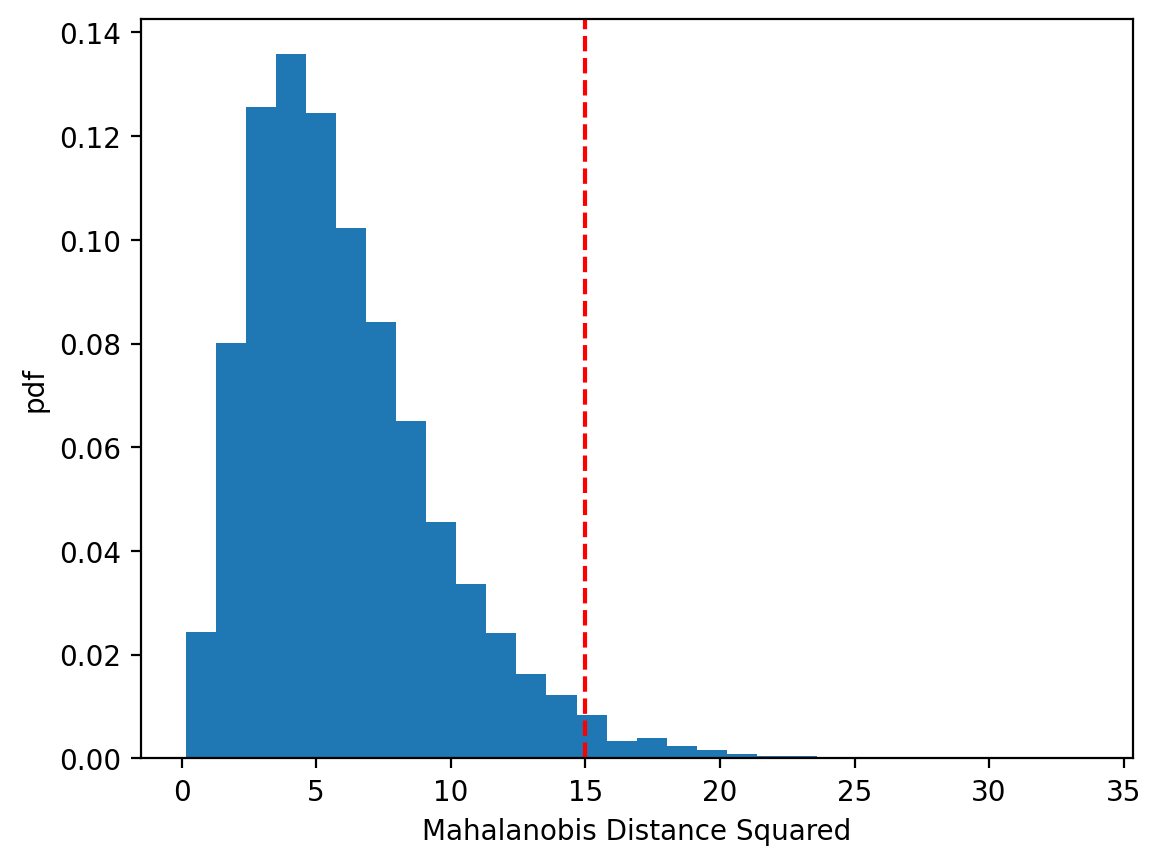

In [2]:
# Create a list of high mahalanobis distance variants
mahalanobis_distance_threshold = 15
mahalanobis_mask = pc.greater_equal(residuals.chi2, mahalanobis_distance_threshold)
residuals_filtered = residuals.apply_mask(mahalanobis_mask)
variants_filtered = variants.apply_mask(mahalanobis_mask)
variants_filtered_ids = variants_filtered.orbit_id
print(f"Number of variants with mahalanobis distance >= {mahalanobis_distance_threshold}: {len(variants_filtered_ids)}")


fig, ax = plt.subplots(1, 1, dpi=200)
ax.hist(residuals.chi2, bins=30, density=True)
ax.set_xlabel("Mahalanobis Distance Squared")
ax.set_ylabel("pdf")
ax.axvline(mahalanobis_distance_threshold, color="red", linestyle="--")

In [3]:
# Inspect the orbit
orbits.to_dataframe()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,00000,367943 Duende (2012 DA14),0.600834,-0.838496,0.069383,0.012377,0.010753,-0.002871,56158,0,"[1.0313585528275123e-14, 8.871621908964226e-15...",SUN


In [4]:
# Show the first 10 variants
variants.to_dataframe().head()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,000001,367943 Duende (2012 DA14),0.600834,-0.838496,0.069383,0.012377,0.010753,-0.002871,56158,0,None,SUN
1,000002,367943 Duende (2012 DA14),0.600834,-0.838496,0.069383,0.012377,0.010753,-0.002871,56158,0,None,SUN
2,000003,367943 Duende (2012 DA14),0.600834,-0.838497,0.069383,0.012377,0.010753,-0.002871,56158,0,None,SUN
3,000004,367943 Duende (2012 DA14),0.600834,-0.838496,0.069383,0.012377,0.010753,-0.002871,56158,0,None,SUN
4,000005,367943 Duende (2012 DA14),0.600834,-0.838496,0.069383,0.012377,0.010753,-0.002871,56158,0,None,SUN


In [5]:
propagated_orbit_file = os.path.join(out_dir, "propagated_orbit.parquet")
propagated_variants_file = os.path.join(out_dir, "propagated_variants.parquet")

# File does not exist, so propagate the orbit (needs PYOORB installed and configured)
if not os.path.exists(propagated_orbit_file):

    from adam_core.propagator import PYOORB

    # Create a propagator (by default PYOORB uses DE430, here we use
    # DE441 which is used by JPL Horizons -- JPL actually uses DE441+n16)
    propagator = PYOORB()

    # Propagate the orbit (mean state)
    propagated_orbit = propagator.propagate_orbits(
        orbits, 
        times,
        parallel_backend="ray"
    )
    propagated_orbit = propagated_orbit.sort_by(["coordinates.time.days", "coordinates.time.nanos"])

    # Propagate the variants
    propagated_variants = propagator.propagate_orbits(
        variants, 
        times, 
        max_processes=20, 
        chunk_size=100,
        parallel_backend="ray"
    )
    propagated_variants = propagated_variants.sort_by(["coordinates.time.days", "coordinates.time.nanos", "orbit_id"])


    # Reconstruct the covariance matrix for the mean state from the variants
    propagated_variants_ = VariantOrbits.from_kwargs(
        orbit_id=pa.array(np.full(len(propagated_variants), "00000")),
        object_id=propagated_variants.object_id,
        coordinates=propagated_variants.coordinates,
        # These weights are only valid for monte-carlo samples
        weights=np.full(len(propagated_variants), 1 / num_samples),
        weights_cov=np.full(len(propagated_variants), 1 / num_samples),
    )
    propagated_orbit_ = propagated_variants_.collapse(propagated_orbit)
    propagated_orbit = propagated_orbit.set_column("coordinates.covariance", propagated_orbit_.coordinates.covariance)

    # Save the propagated orbit and variants
    propagated_orbit.to_parquet(propagated_orbit_file)
    propagated_variants.to_parquet(propagated_variants_file)

else:
    propagated_orbit = Orbits.from_parquet(propagated_orbit_file)
    propagated_variants = VariantOrbits.from_parquet(propagated_variants_file)

In [6]:
# The propagated orbit (mean state)
propagated_orbit.to_dataframe().head()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,00000,367943 Duende (2012 DA14),0.082424,-0.858101,0.138496,0.018383,0.002876,-0.002555,58999,86399999999749,"[1.182319982641957e-10, 2.0983578913908938e-11...",SUN
1,00000,367943 Duende (2012 DA14),0.173707,-0.838942,0.124967,0.018094,0.004788,-0.002852,59005,250,"[1.1485753106240369e-10, 3.300051742842425e-11...",SUN
2,00000,367943 Duende (2012 DA14),0.263007,-0.810230,0.110016,0.017589,0.006693,-0.003124,59009,86399999999695,"[1.0881480751195273e-10, 4.411812664257785e-11...",SUN
3,00000,367943 Duende (2012 DA14),0.349236,-0.772071,0.093783,0.016865,0.008563,-0.003364,59014,86399999999910,"[1.0025978085796895e-10, 5.3712753205224525e-1...",SUN
4,00000,367943 Duende (2012 DA14),0.431297,-0.724707,0.076431,0.015923,0.010370,-0.003570,59020,106,"[8.950717184824205e-11, 6.118316724882562e-11,...",SUN


In [7]:
# To access the orbit at each time
times_isot = propagated_orbit.coordinates.time.to_astropy().isot
times_mjd = propagated_orbit.coordinates.time.to_astropy().mjd
states = propagated_orbit.coordinates.values
# The units of the state vector are au and au per day
print(times_isot[0], states[0])
print(states.shape)

2020-05-31T00:00:00.000 [ 0.08242434 -0.85810133  0.13849624  0.01838333  0.00287634 -0.00255543]
(200, 6)


In [8]:
# To access the covariance matrix at each time
# Internally they are stored as 1D arrays but can be reconstructed to 6x6 matrices
# using the `to_matrix` method
covariances = propagated_orbit.coordinates.covariance
covariance_matrices = covariances.to_matrix()
print(times_isot[0], covariance_matrices[0])
print(covariance_matrices.shape)

2020-05-31T00:00:00.000 [[ 1.18231998e-10  2.09835789e-11 -1.69543807e-11 -2.02614426e-13
   2.48816805e-12 -4.03441903e-13]
 [ 2.09835789e-11  3.72533895e-12 -3.00910638e-12 -3.59295760e-14
   4.41570232e-13 -7.16036304e-14]
 [-1.69543807e-11 -3.00910638e-12  2.43128813e-12  2.90526637e-14
  -3.56799965e-13  5.78527784e-14]
 [-2.02614426e-13 -3.59295760e-14  2.90526637e-14  3.47963779e-16
  -4.26459278e-15  6.91343610e-16]
 [ 2.48816805e-12  4.41570232e-13 -3.56799965e-13 -4.26459278e-15
   5.23634930e-14 -8.49031830e-15]
 [-4.03441903e-13 -7.16036304e-14  5.78527784e-14  6.91343610e-16
  -8.49031830e-15  1.37667214e-15]]
(200, 6, 6)


Text(0, 0.5, '$\\sigma_r$ [au]')

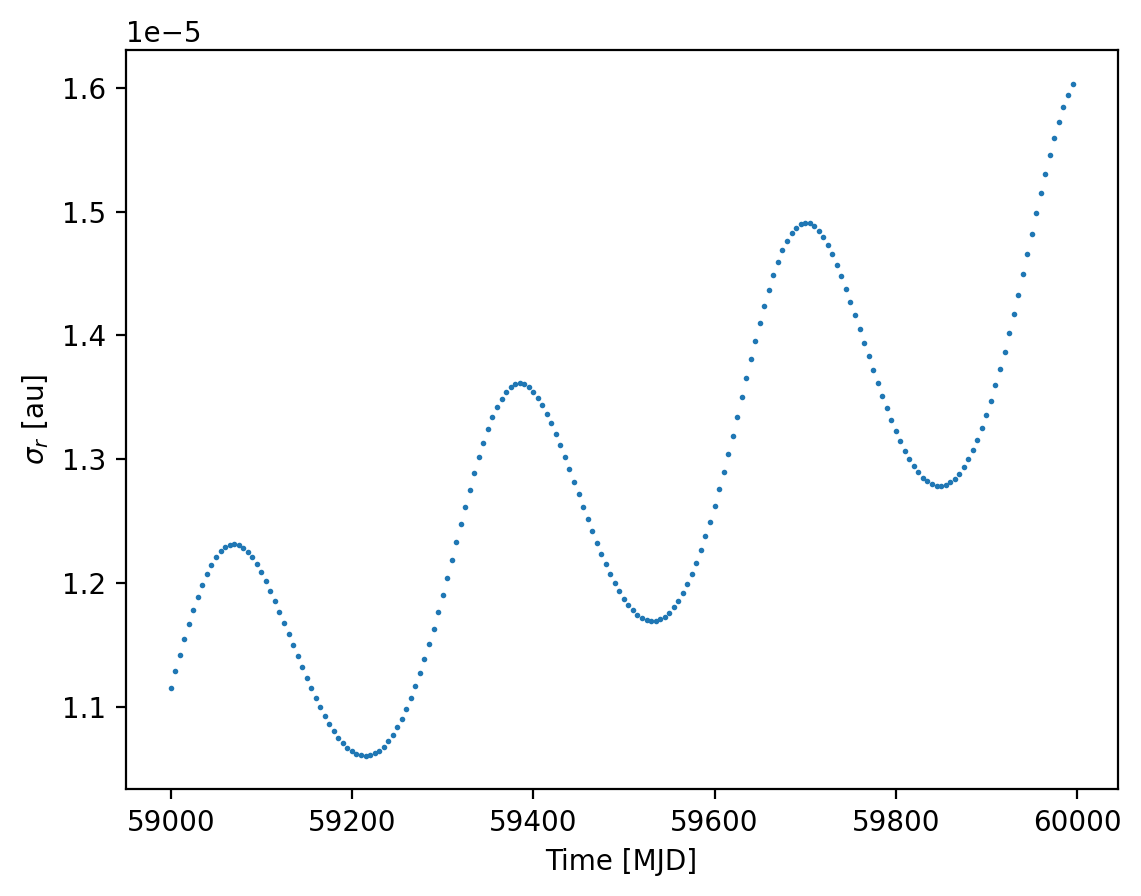

In [9]:
# We can plot how the covariance matrix grows with time (limiting just to the uncertainity in the positional components)
# sigma_r
# Note that after a while the covariance matrix actually poorly approximates the true uncertainty (we get to the point
# where a ring like shape is approximated by a sphere of equal radius..)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(times_mjd, propagated_orbit.coordinates.sigma_r_mag, s=1)
ax.set_xlabel("Time [MJD]")
ax.set_ylabel("$\sigma_r$ [au]")

In [10]:
# Propagated variants 
propagated_variants.to_dataframe().head()

,orbit_id,object_id,weights,weights_cov,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,000001,367943 Duende (2012 DA14),NaN,NaN,0.082436,-0.858099,0.138495,0.018383,0.002877,-0.002555,58999,86399999999749,None,SUN
1,000002,367943 Duende (2012 DA14),NaN,NaN,0.082413,-0.858103,0.138498,0.018383,0.002876,-0.002555,58999,86399999999749,None,SUN
2,000003,367943 Duende (2012 DA14),NaN,NaN,0.082404,-0.858105,0.138499,0.018383,0.002876,-0.002555,58999,86399999999749,None,SUN
3,000004,367943 Duende (2012 DA14),NaN,NaN,0.082416,-0.858103,0.138497,0.018383,0.002876,-0.002555,58999,86399999999749,None,SUN
4,000005,367943 Duende (2012 DA14),NaN,NaN,0.082409,-0.858104,0.138499,0.018383,0.002876,-0.002555,58999,86399999999749,None,SUN


In [11]:
import os
import spiceypy as sp
from astropy import units as u

import matplotlib.colors 

import pyarrow.compute as pc

from naif_leapseconds import leapseconds
sp.furnsh(leapseconds)

def add_renderable_trail_orbit(
        name: str, 
        object_id: str, 
        target_id: str, 
        kernel_file: str, 
        period: float,
        sample_interval: int = 3600, 
        tag: str = "THOR",
        opacity: float = 1.0,
        rgb: tuple = (1.0, 1.0, 1.0),
        line_width: int = 1,
    ):
    return f"""local {name} = {{
    Identifier = "{object_id}_trail",
    Parent = "SunCenter",
    Renderable = {{
        Type = "RenderableTrailOrbit",
        Enabled = true,
        Translation = {{
            Type = "SpiceTranslation",
            Target = "{target_id}",
            Observer = "SUN",
            Kernels = {{
                asset.localResource("{kernel_file}")
            }},
        }},
        Color = {{{rgb[0]},{rgb[1]},{rgb[2]}}},
        Opacity = {opacity},
        Period = {period},
        Resolution = {sample_interval},
        LineWidth = {line_width},
        SampleInterval = {sample_interval}
    }},
    Opacity = {opacity},
    Tag = {{"{tag}"}},
    GUI = {{
        Name = "trail_{object_id}",
        Path = "/ADAM"
    }}
}}"""

def add_renderable_trail_head( 
        name: str, 
        object_id: str,  
        target_id: str, 
        kernel_file: str, 
        tag: str = "THOR",
    ):
    return f"""local {name} = {{
    Identifier = "{object_id}",
    Parent = "SunCenter",
    Transform = {{
        Translation = {{
            Type = "SpiceTranslation",
            Target = "{target_id}",
            Observer = "SUN",
            Kernels = {{
                asset.localResource("{kernel_file}")
            }},
        }},
    }},
    Tag = {{"{tag}"}},
    GUI = {{
        Name = "{object_id}",
        Path = "/ADAM"
    }}
}}"""


# 60 default for sample_interval
def create_openspace_assets(
        propagated_orbits, 
        out_dir, 
        tag="ADAM",
        sample_interval=86400, 
        color="green", 
        orbit_properties=None, 
        id_offset=1000000,
        line_width=2,
    ):
    os.makedirs(out_dir, exist_ok=True)
    
    out_asset = open(os.path.join(out_dir, "all.asset"), "w")
    out_asset.write("local assetHelper = asset.require('util/asset_helper')\n",)

    orbit_ids = propagated_orbits.orbit_id.unique().to_numpy(zero_copy_only=False)

    if orbit_properties is None or "color" not in orbit_properties.columns:
        colors = [color] * len(orbit_ids)
        rgb = [matplotlib.colors.to_rgb(color) for color in colors]
    else:
        rgb = orbit_properties["color"].values

    if orbit_properties is None or "opacity" not in orbit_properties.columns:
        opacity = [1] * len(orbit_ids)
    else:
        opacity = orbit_properties["opacity"].values

    for i, orbit_id in enumerate(orbit_ids):


        mask = pc.equal(propagated_orbits.orbit_id, orbit_id)
        propagated_orbit = propagated_orbits.apply_mask(mask)
        propagated_orbit = propagated_orbit.sort_by(["coordinates.time.days", "coordinates.time.nanos"])

        keplerian = propagated_orbit.coordinates.to_keplerian()
        orbital_period = keplerian.P[0]
            
        target_id = id_offset + i
        
        epochs_tdb = propagated_orbit.coordinates.time.rescale("tdb").jd().to_numpy(zero_copy_only=False)
        epochs_et = np.array([sp.str2et(f'JD {i:.15f} TDB'.format(i)) for i in epochs_tdb])
        
        states = propagated_orbit.coordinates.values
        states[:, 0:6] *= u.au.to(u.km)
        states[:, 3:6] /= (u.d).to(u.s)

        out_bsp = os.path.join(out_dir, f"{orbit_id}.bsp")
        file = sp.spkopn(out_bsp, f"{target_id}", 0)
        sp.spkw09(
            file, 
            target_id,
            10,
            "ECLIPJ2000",
            epochs_et[0],
            epochs_et[-1],
            "SPK_STATES_09",
            15,
            len(epochs_et),
            np.ascontiguousarray(states),
            epochs_et,
        )
        sp.spkcls(file)
        
        asset = add_renderable_trail_orbit(
            f"trail{i}",
            orbit_id,
            target_id,
            os.path.basename(out_bsp),
            orbital_period * 365.25,
            sample_interval=sample_interval, 
            tag=tag,
            opacity=opacity[i],
            rgb=rgb[i],
            line_width=line_width,
        )
        asset += "\n"
        asset += add_renderable_trail_head(
            f"head{i}",
            orbit_id,
            target_id,
            os.path.basename(out_bsp),
            tag=tag,
        )

        out_asset.write(asset)
        out_asset.write("\n")
        
        asset += "\n"
        asset += f"assetHelper.registerSceneGraphNodesAndExport(asset, {{trail{i}, head{i}}})"
        
        asset_file = open(os.path.join(out_dir, f"{orbit_id}.asset"), "w")
        asset_file.write("local assetHelper = asset.require('util/asset_helper')\n",)
        asset_file.write(asset)
        asset_file.close()
        

    out_asset.write("assetHelper.registerSceneGraphNodesAndExport(asset, {\n")
    for i in range(len(orbit_ids)):
        out_asset.write(f"  trail{i},\n")
        out_asset.write(f"  head{i},\n")
    out_asset.write("})\n")
    out_asset.close()
   
    return 


In [13]:
LIMIT_TO_FILTERED = True
if LIMIT_TO_FILTERED:
    mask = pc.is_in(propagated_variants.orbit_id, variants_filtered_ids)
else:
    mask = pa.array([True] * len(propagated_variants))


create_openspace_assets(propagated_orbit, os.path.join(out_dir, "openspace_orbit"), color="blue")
create_openspace_assets(propagated_variants.apply_mask(mask), os.path.join(out_dir, "openspace_variants"))